In [18]:
#!pip install numpy pandas scikit-learn seaborn matplotlib statsmodels scipy



In [19]:
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import shapiro
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd


# 2. Modelo de regresión lineal multiple

La regresión lineal múltiple es una extensión de la regresión lineal simple. Mientras que en la regresión lineal simple se modela la relación entre una variable dependiente 𝑌 y una única variable independiente 𝑋, en la regresión lineal múltiple se modela la relación entre 𝑌 y varias variables independientes X1, 𝑋2, ..., 𝑋𝑛

### Diferencias clave entre la regresión lineal simple y múltiple
**Número de variables independientes:** 

Regresión lineal simple: Tiene una sola variable independiente. La ecuación es de la forma:

𝑌=𝛽0+𝛽1𝑋+𝜀

Regresión lineal múltiple: Tiene varias variables independientes. La ecuación general se amplía a:

𝑌=𝛽0+𝛽1𝑋1+𝛽2𝑋2+⋯+𝛽𝑛𝑋𝑛+𝜀

Donde 
Y es la variable dependiente,
𝑋1, 𝑋2,…,𝑋𝑛 son las variables independientes, 
𝛽0 es el intercepto, 
𝛽1, 𝛽2, …, 𝛽𝑛 Son los coeficientes de regresión de cada variable independiente, 
ε es el término de error.

Complejidad y cálculo:

Simple: Solo se estima un coeficiente de pendiente y un intercepto.
Múltiple: Se estiman varios coeficientes de regresión (uno para cada variable independiente) y un intercepto. Esto aumenta la complejidad de los cálculos y, en algunos casos, puede requerir métodos más avanzados de optimización y análisis.
Interpretación de coeficientes:

Simple: El coeficiente 𝛽1 representa el cambio esperado en 𝑌 por cada unidad de cambio en 𝑋.
Múltiple: Cada coeficiente 𝛽𝑖 representa el cambio esperado en 𝑌 cuando 𝑋𝑖 cambia una unidad, manteniendo constantes las demás variables independientes. Esto se llama interpretación "ceteris paribus" y es importante en modelos con múltiples variables, donde las variables independientes pueden interactuar o influenciarse entre sí.

Ajuste y predicción:

Múltiple: En general, la regresión múltiple permite capturar más variabilidad de la variable dependiente Y al considerar múltiples factores, lo que puede mejorar el ajuste del modelo (reflejado en un valor 𝑅2 mayor).

Simple: La variabilidad en Y solo se explica por una variable independiente, lo que a veces limita el ajuste del modelo.

Multicolinealidad:

Múltiple: La presencia de múltiples variables puede causar multicolinealidad, donde algunas variables independientes están altamente correlacionadas entre sí. Esto puede hacer que los coeficientes sean inestables y difíciles de interpretar. El nombre viene de linealidad y de co en relacion a que la variable dependiente es afectada por dos o mas variables que tienen relación entre sí. POr ejemplo La multicolinealidad surge porque las variables independientes (educación, salud, experiencia laboral, y red de contactos) están correlacionadas entre sí y con el ingreso, lo cual dificulta distinguir el efecto específico de cada variable sobre el ingreso.

Simple: No existe el problema de multicolinealidad porque solo hay una variable independiente.

* "Estatura_Padres": "Estatura promedio de los padres"
* "Estatura_Hijos": "Estatura de los hijos"
* "Ejercicio": "Cantidad de ejercicio físico en horas promedio por semana"
* "Alimentacion": "Calidad de la alimentación en una escala de 1 a 10"
* "Sueno": "Promedio de horas de sueño por noche"
* "Nivel_Socioeconomico": "Nivel socioeconómico en una escala de 1 a 5"


In [20]:
# Establecer la semilla para reproducibilidad
np.random.seed(123)

# Generar datos simulados para estatura de padres e hijos
estatura_padres = np.random.normal(loc=170, scale=10, size=100)
estatura_hijos = 50 + 0.8 * estatura_padres + np.random.normal(loc=0, scale=5, size=100)

# Crear variables de control con correlaciones moderadas con la estatura de los hijos
# Ejercicio: Relación baja con la estatura de los hijos más un término aleatorio
ejercicio = 0.05 * estatura_hijos + np.random.normal(loc=3, scale=1, size=100)

# Alimentación: Relación baja con la estatura de los hijos más un término aleatorio
alimentacion = 0.02 * estatura_hijos + np.random.normal(loc=7, scale=1.5, size=100)

# Sueño: Relación leve con la estatura de los hijos más un término aleatorio
sueno = 0.03 * estatura_hijos + np.random.normal(loc=8, scale=1, size=100)

# Nivel Socioeconómico: Relación baja con la estatura de los hijos más un término aleatorio
nivel_socioeconomico = 0.01 * estatura_hijos + np.random.normal(loc=3, scale=1, size=100)

# Crear el DataFrame con todas las variables
df_estatura = pd.DataFrame({
    'Estatura_Padres': estatura_padres,
    'Estatura_Hijos': estatura_hijos,
    'Ejercicio': ejercicio,
    'Alimentacion': alimentacion,
    'Sueno': sueno,
    'Nivel_Socioeconomico': nivel_socioeconomico
})

# Calcular el rango intercuartílico (IQR) y filtrar valores atípicos
def eliminar_outliers(df):
    df_limpio = df.copy()
    for columna in df.columns:
        # Calcular Q1 (25%) y Q3 (75%) y el IQR
        Q1 = df[columna].quantile(0.25)
        Q3 = df[columna].quantile(0.75)
        IQR = Q3 - Q1
        
        # Determinar límites para valores no atípicos
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        
        # Filtrar outliers
        df_limpio = df_limpio[(df_limpio[columna] >= limite_inferior) & (df_limpio[columna] <= limite_superior)]
    
    return df_limpio

# Aplicar la función de eliminación de outliers
df_estatura = eliminar_outliers(df_estatura)

# Mostrar el DataFrame limpio y revisar la correlación
print("\nCorrelación después de limpiar los datos:")
print(df_estatura.corr())

# Mostrar el DataFrame y revisar la correlación
df_estatura


Correlación después de limpiar los datos:
                      Estatura_Padres  Estatura_Hijos  Ejercicio  \
Estatura_Padres              1.000000        0.866805   0.342417   
Estatura_Hijos               0.866805        1.000000   0.426259   
Ejercicio                    0.342417        0.426259   1.000000   
Alimentacion                -0.005546        0.076355   0.269872   
Sueno                        0.235137        0.199836   0.157258   
Nivel_Socioeconomico         0.379356        0.363785   0.244064   

                      Alimentacion     Sueno  Nivel_Socioeconomico  
Estatura_Padres          -0.005546  0.235137              0.379356  
Estatura_Hijos            0.076355  0.199836              0.363785  
Ejercicio                 0.269872  0.157258              0.244064  
Alimentacion              1.000000  0.192503             -0.054296  
Sueno                     0.192503  1.000000              0.126207  
Nivel_Socioeconomico     -0.054296  0.126207              1.000000

,Estatura_Padres,Estatura_Hijos,Ejercicio,Alimentacion,Sueno,Nivel_Socioeconomico
0,159.143694,180.525229,12.729572,11.758087,14.949847,5.557286
1,179.973454,184.089324,11.606361,9.438303,12.992766,4.910534
2,172.829785,191.825151,14.791960,9.847776,13.263782,4.652806
3,154.937053,186.941162,13.035355,11.655509,12.299070,5.798996
4,164.213997,181.248068,12.056096,10.408941,13.428782,6.073302
...,...,...,...,...,...,...
95,180.311145,178.093641,12.600469,9.950604,13.910689,5.056278
96,159.154321,175.976989,13.674650,10.082280,13.792293,4.129152
97,156.365285,174.537974,12.142593,10.858829,13.209217,3.351005
98,173.794006,187.328896,12.526989,10.493938,13.931448,5.785977


In [21]:
df_estatura.to_csv('df_estatura.csv', index=False)

# Pasos
1. Como en el escenario anterior, hay que ver si la variable tiene una relación lineal (exploración visual y matriz de correlación), si la tiene comprobar que no hay multicolinealidad. 
2. Ajustar modelo y obtener
3. Visualizar los valores predichos vs los valores reales para tener una idea visual del ajuste. 

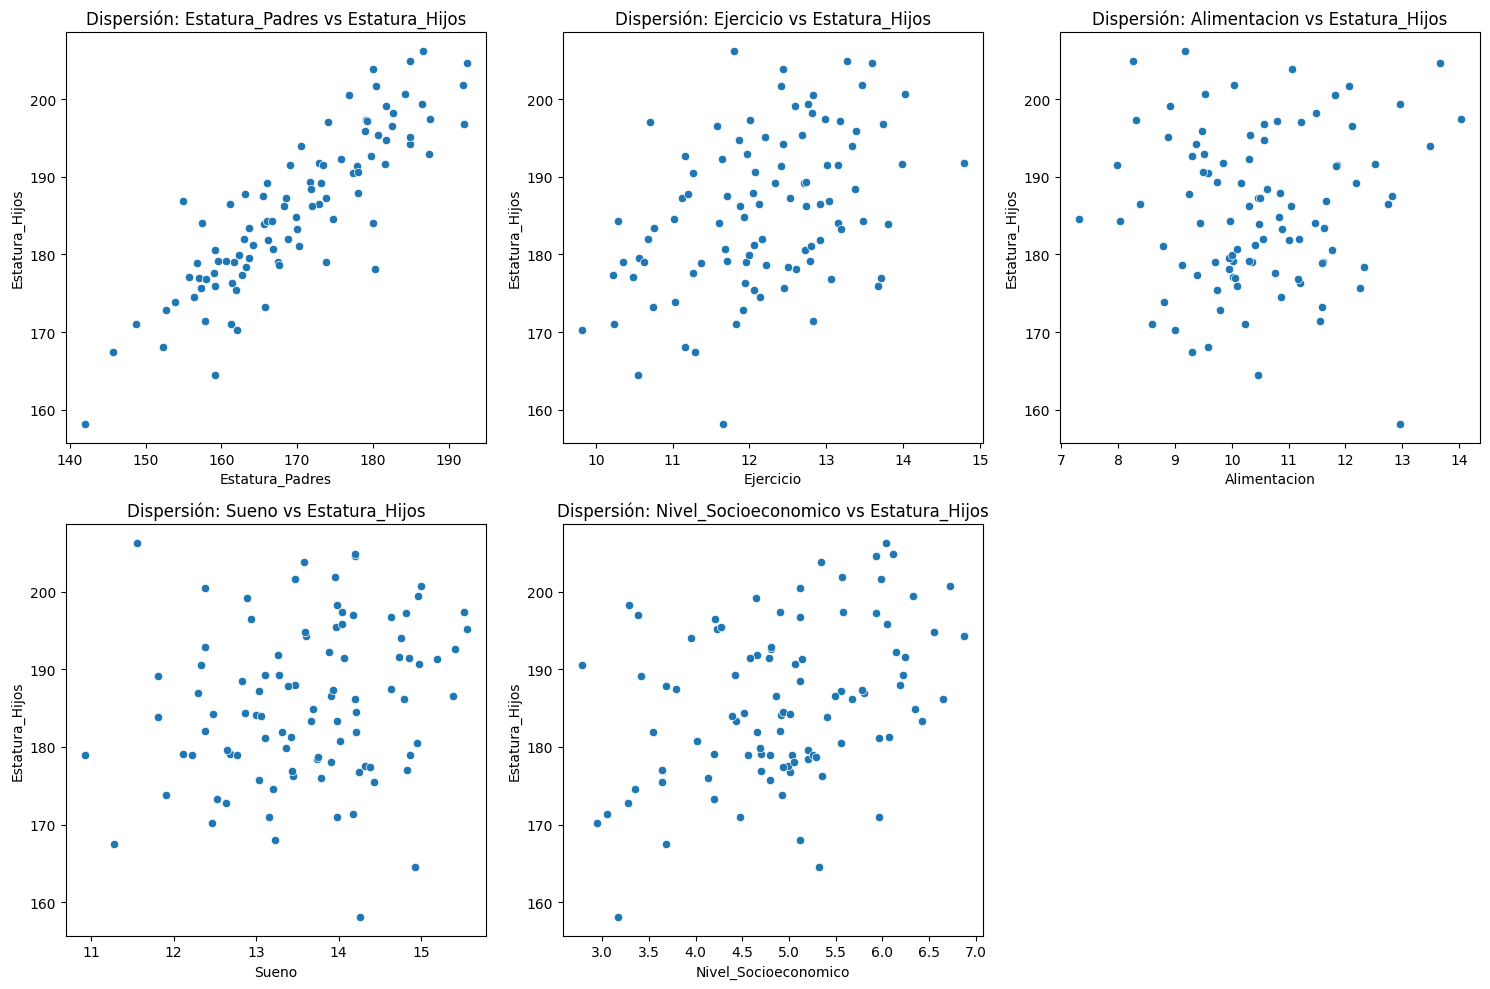

In [22]:
# Graficar dispersión de cada variable independiente con respecto a la variable dependiente (Estatura_Hijos)
variables_independientes = ['Estatura_Padres', 'Ejercicio', 'Alimentacion', 'Sueno', 'Nivel_Socioeconomico']
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables_independientes, 1):
    plt.subplot(2, 3, i)  # Configuración de la cuadrícula de gráficos
    sns.scatterplot(data=df_estatura, x=var, y='Estatura_Hijos')
    plt.title(f"Dispersión: {var} vs Estatura_Hijos")
    plt.xlabel(var)
    plt.ylabel('Estatura_Hijos')
plt.tight_layout()
plt.show()

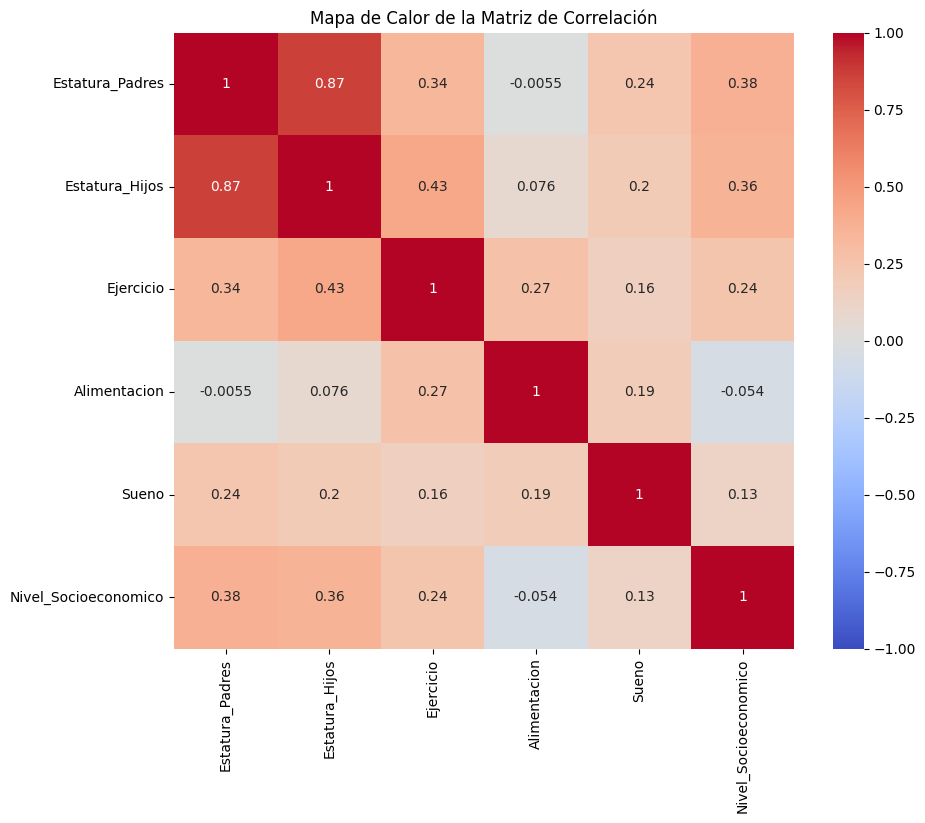

In [23]:
# Paso 1: Gráfico de Correlación
plt.figure(figsize=(10, 8))
sns.heatmap(df_estatura.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Mapa de Calor de la Matriz de Correlación")
plt.show()



In [24]:
# Paso 2: Cálculo del VIF
X = df_estatura[variables_independientes]
X = sm.add_constant(X)  # Agrega el intercepto para el cálculo del VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("Factor de Inflación de Varianza (VIF):")
print(vif_data)



Factor de Inflación de Varianza (VIF):
               Variable         VIF
0                 const  407.334098
1       Estatura_Padres    1.321027
2             Ejercicio    1.267001
3          Alimentacion    1.142466
4                 Sueno    1.105973
5  Nivel_Socioeconomico    1.203471


Cálculo del VIF (Factor de Inflación de Varianza):

Para detectar multicolinealidad, calcula el VIF para cada variable independiente.
Un valor de VIF superior a 5 (o en algunos casos, 10) sugiere alta multicolinealidad y podría ser conveniente eliminar o combinar esas variables, ya que podrían redundar en la explicación de la variabilidad de Estatura_Hijos.


VIF < 5: Generalmente, no hay problema de multicolinealidad.

VIF > 5: Existe cierta multicolinealidad, y deberías investigar más.

VIF > 10: Indica una alta multicolinealidad, y podría ser recomendable eliminar o transformar la variable.

In [25]:
# Paso 3: Regresión Múltiple y R-cuadrado ajustado
y = df_estatura['Estatura_Hijos']
modelo = sm.OLS(y, X).fit()  # Ajuste del modelo con statsmodels
print("\nResumen del modelo de regresión múltiple:")
print(modelo.summary())




Resumen del modelo de regresión múltiple:
                            OLS Regression Results                            
Dep. Variable:         Estatura_Hijos   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     60.76
Date:                Fri, 07 Feb 2025   Prob (F-statistic):           3.24e-27
Time:                        18:55:07   Log-Likelihood:                -282.52
No. Observations:                  95   AIC:                             577.0
Df Residuals:                      89   BIC:                             592.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

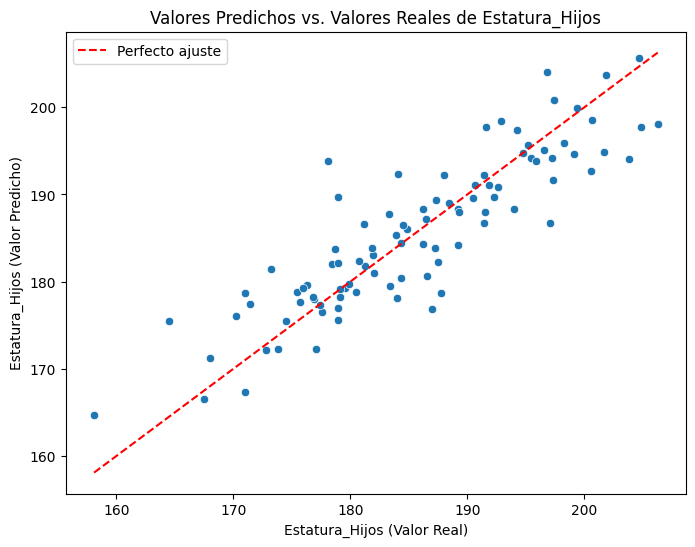

In [26]:
# Obtener los valores predichos usando el modelo ajustado
y_pred = modelo.predict(X)  # X es el DataFrame de las variables independientes

#añadir los valores predichos al DataFrame original para visualización
df_estatura['Estatura_Hijos_Pred'] = y_pred

# Gráfico de valores predichos vs. valores reales
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_estatura['Estatura_Hijos'], y=df_estatura['Estatura_Hijos_Pred'])
plt.plot([df_estatura['Estatura_Hijos'].min(), df_estatura['Estatura_Hijos'].max()],
         [df_estatura['Estatura_Hijos'].min(), df_estatura['Estatura_Hijos'].max()],
         color='red', linestyle='--', label='Perfecto ajuste')

# Etiquetas y título
plt.xlabel('Estatura_Hijos (Valor Real)')
plt.ylabel('Estatura_Hijos (Valor Predicho)')
plt.title('Valores Predichos vs. Valores Reales de Estatura_Hijos')
plt.legend()

plt.show()

## Evaluación

1. Linealidad ya la hemos explorado y comprobado. Si no de entrada no habríamos corrido el modelo

2. Independencia de errores (respecto a sí mismos)

Estadístico de Durbin-Watson: 1.9384262764703195


Text(0.5, 1.0, 'Gráfico de Residuos vs. Valores Predichos')

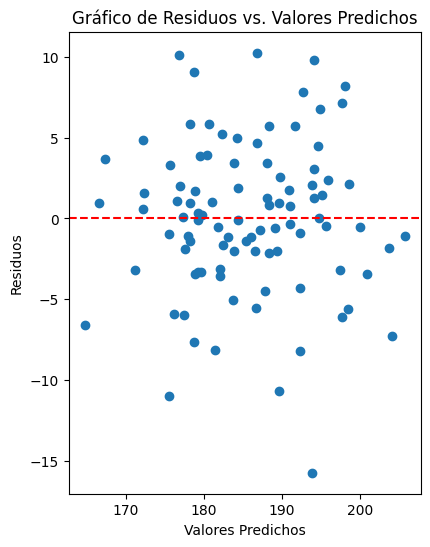

In [27]:

# Calcular el estadístico de Durbin-Watson
dw_stat = durbin_watson(modelo.resid)
print(f"Estadístico de Durbin-Watson: {dw_stat}")

# Gráfico de residuos vs. valores predichos
plt.figure(figsize=(10, 6))

# Residuos vs Valores Predichos
plt.subplot(1, 2, 1)
plt.scatter(modelo.fittedvalues, modelo.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos vs. Valores Predichos')




3. Homocedasticidad

In [28]:
# Realizar la Prueba de Breusch-Pagan
lm_stat, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(modelo.resid, modelo.model.exog)
print("Prueba de Breusch-Pagan para Homocedasticidad:")
print(f"LM Statistic: {lm_stat}, p-valor LM: {lm_pvalue}")
print(f"F-Statistic: {fvalue}, p-valor F: {f_pvalue}")



Prueba de Breusch-Pagan para Homocedasticidad:
LM Statistic: 3.8060604758322447, p-valor LM: 0.577662659095504
F-Statistic: 0.7428988902476326, p-valor F: 0.5933936761044349


En la regresión múltiple, hay más detalles (como el estadístico F) porque el modelo considera varias variables independientes, y esta información adicional puede ser útil.
En la regresión simple, el resultado se simplifica al dar el estadístico LM y el p-valor para probar homocedasticida

4. Normalidad de los residuos

Resultados de la Prueba de Shapiro-Wilk para los residuos:
Estadístico de Shapiro-Wilk: 0.9851607290359714
p-valor de Shapiro-Wilk: 0.3613882628338005


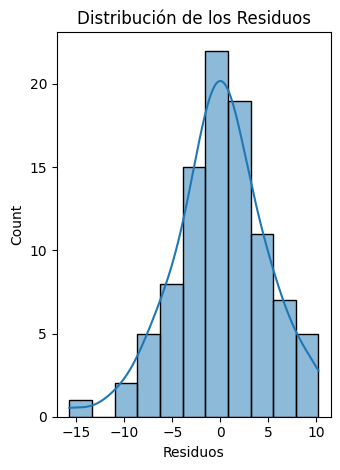

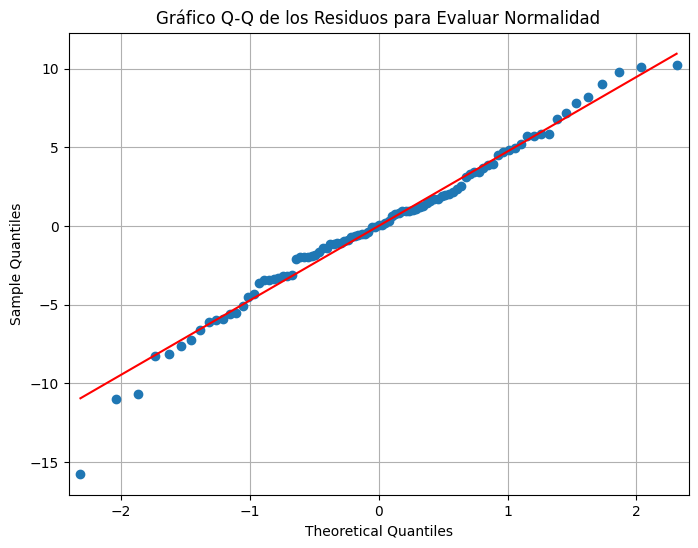

In [29]:
# Prueba de Shapiro-Wilk para los residuos
shapiro_stat, shapiro_pvalue = stats.shapiro(modelo.resid)
print("Resultados de la Prueba de Shapiro-Wilk para los residuos:")
print(f"Estadístico de Shapiro-Wilk: {shapiro_stat}")
print(f"p-valor de Shapiro-Wilk: {shapiro_pvalue}")

# Histograma de los residuos para verificar normalidad
plt.subplot(1, 2, 2)
sns.histplot(modelo.resid, kde=True)
plt.xlabel('Residuos')
plt.title('Distribución de los Residuos')

plt.tight_layout()
plt.show()
# Gráfico Q-Q
plt.figure(figsize=(8, 6))
sm.qqplot(modelo.resid, line='s', ax=plt.gca())
plt.title("Gráfico Q-Q de los Residuos para Evaluar Normalidad")
plt.grid(True)
plt.show()



5. Multicolinealidad. Se hizo antes

## Modelo en DC

In [30]:
# Definir variables independientes y dependiente
X = df_estatura[['Estatura_Padres', 'Ejercicio', 'Alimentacion', 'Sueno', 'Nivel_Socioeconomico']]
y = df_estatura['Estatura_Hijos']

# Dividir los datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y ajustar el modelo en el conjunto de entrenamiento
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred = modelo.predict(X_test)


# Imprimir los coeficientes del modelo
y = df_estatura['Estatura_Hijos']
modelo_split = sm.OLS(y_train, X_train).fit()  # Ajuste del modelo con statsmodels
print("\nResumen del modelo de regresión múltiple tras dividir datos:")
print(modelo_split.summary())


y = df_estatura['Estatura_Hijos']
modelo = sm.OLS(y, X).fit()  # Ajuste del modelo con statsmodels
print("\nResumen del modelo de regresión múltiple sin dividir:")
print(modelo.summary())


Resumen del modelo de regresión múltiple tras dividir datos:
                                 OLS Regression Results                                
Dep. Variable:         Estatura_Hijos   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.716e+04
Date:                Fri, 07 Feb 2025   Prob (F-statistic):                   6.19e-108
Time:                        18:55:08   Log-Likelihood:                         -235.20
No. Observations:                  76   AIC:                                      480.4
Df Residuals:                      71   BIC:                                      492.0
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t     

Podemos notar que los resultados son distintos. Tiene que ver con el sampleo. 

In [31]:
# Calcular métricas de rendimiento
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir los resultados
print(f"Error Cuadrático Medio (MSE) en el conjunto de prueba: {mse:.2f}")
print(f"Coeficiente de Determinación (R^2) en el conjunto de prueba: {r2:.2f}")

Error Cuadrático Medio (MSE) en el conjunto de prueba: 19.77
Coeficiente de Determinación (R^2) en el conjunto de prueba: 0.77


MSE evalúa la precisión general de las predicciones del modelo en comparación con los valores reales, mientras que el error estándar evalúa la precisión de los coeficientes del modelo.Cada valor predicho se aleja en promedio 3 unidades del valor real

## Despliegue

In [32]:
# Guardar el modelo entrenado en un archivo .pkl
with open('modelo_entrenado_multiple.pkl', 'wb') as file:
    pickle.dump(modelo_split, file)

print("Modelo exportado exitosamente en 'modelo_entrenado_multiple.pkl'")


Modelo exportado exitosamente en 'modelo_entrenado_multiple.pkl'


In [33]:
from flask import Flask, render_template, request
import pickle
import numpy as np

# Cargar el modelo desde el archivo .pkl
with open('modelo_entrenado_multiple.pkl', 'rb') as file:
    modelo = pickle.load(file)

# Inicializa la aplicación Flask
app = Flask(__name__)

# Ruta principal para la página de inicio
@app.route('/', methods=['GET', 'POST'])
def index():
    resultado = None
    if request.method == 'POST':
        try:
            # Obtener los valores ingresados por el usuario
            estatura_padres = float(request.form.get('estatura_padres'))
            ejercicio = float(request.form.get('ejercicio'))
            alimentacion = float(request.form.get('alimentacion'))
            sueno = float(request.form.get('sueno'))
            nivel_socioeconomico = float(request.form.get('nivel_socioeconomico'))

            # Crear el array de características para la predicción
            entrada = np.array([[estatura_padres, ejercicio, alimentacion, sueno, nivel_socioeconomico]])

            # Realizar la predicción usando el modelo cargado
            estatura_hijo_predicha = modelo.predict(entrada)[0]
            resultado = f"Predicción de estatura del hijo: {estatura_hijo_predicha:.2f} cm"
        except ValueError:
            resultado = "Por favor, ingresa valores numéricos válidos para todas las variables."
    
    # Renderizar el template HTML con el resultado
    return render_template('index_multiple.html', resultado=resultado)

# Ejecutar la aplicación
if __name__ == '__main__':
    app.run(debug=False)


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
